## DCOPF using CVXPY
- This code references the work of Jip Kim.

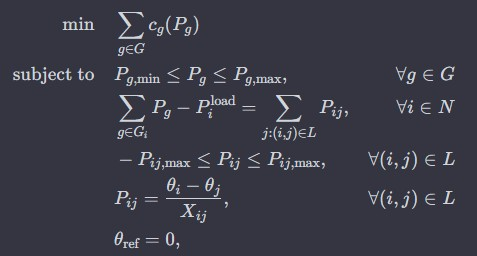

In [16]:
import numpy as np
import cvxpy as cp
from IPython.display import Image

from math import radians
from readnetwork import readnetwork
from ybus import ybus

display(Image(filename='dcopfformulation.jpg'))

In [101]:
testsystem = 'case_ieee30'

In [102]:
buses, lines, generators, datamat = readnetwork(testsystem)
# inline: 다른 버스에서 이 버스로 들어오는(matpower data에서 from이랑 to) line의 인덱스가 표기되어 있음.
# outline: 이 버스에서 다른 버스로 향하는 line의 인덱스가 표기되어 있음.
print(buses[0])
print(buses[1])
print(buses[2])
print(buses[3])
print(lines[0])
print(generators[0])

Bus(bindex=1.0, btype=3.0, Pd=0.0, Qd=0.0, Gs=0.0, Bs=0.0, area=1.0, Vm=1.06, Va=0.0, baseKV=132.0, bzone=1.0, Vmax=1.06, Vmin=0.94, inline=[], outline=[0, 1])
Bus(bindex=2.0, btype=2.0, Pd=0.217, Qd=0.127, Gs=0.0, Bs=0.0, area=1.0, Vm=1.043, Va=-0.09564404300928926, baseKV=132.0, bzone=1.0, Vmax=1.06, Vmin=0.94, inline=[0], outline=[2, 4, 5])
Bus(bindex=3.0, btype=1.0, Pd=0.024, Qd=0.012, Gs=0.0, Bs=0.0, area=1.0, Vm=1.021, Va=-0.13892820845874862, baseKV=132.0, bzone=1.0, Vmax=1.06, Vmin=0.94, inline=[1], outline=[3])
Bus(bindex=4.0, btype=1.0, Pd=0.076, Qd=0.016, Gs=0.0, Bs=0.0, area=1.0, Vm=1.012, Va=-0.1679006740418545, baseKV=132.0, bzone=1.0, Vmax=1.06, Vmin=0.94, inline=[2, 3], outline=[6, 14])
Line(lindex=1, fbus=0, tbus=1, r=0.0192, x=0.0575, b=0.0528, u=0.0, shft=0.0, tap=0.0, angmin=-6.283185307179586, angmax=6.283185307179586)
Generator(gindex=1, gtype='NotDefined', location=0, Pg=2.602, Qg=-0.161, Qmax=0.1, Qmin=0.0, Vg=1.06, mBase=100.0, status=1.0, Pmax=3.602, Pmin=0.0,

In [103]:
nline = len(lines)
nbus = len(buses)
ngen = len(generators)
lineset = np.arange(0, nline)
busset = np.arange(0, nbus)
genset = np.arange(0, ngen)
baseMVA = datamat['baseMVA'][0,0][0,0]

In [104]:
Ybus, yff, yft, ytf, ytt = ybus( buses, lines )

yff_r = np.real(yff)
yff_i = np.imag(yff)
ytt_r = np.real(ytt)
ytt_i = np.imag(ytt)
yft_r = np.real(yft)
yft_i = np.imag(yft)
ytf_r = np.real(ytf)
ytf_i = np.imag(ytf)

In [105]:
B_g = []
for g in genset:
    B_g.append( generators[g].location )

B_gn = []
for i in busset:
    B_gn.append( [] )

for g in genset:
    B_gn[ generators[g].location ].append( int(g) )

# B_gn
# # [[0], [1], [], [], [2], [], [], [3], [], [], [4], [], [5], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [106]:
theta = cp.Variable( len(busset) )
pg = cp.Variable( len(genset) )
p_ft = cp.Variable( len(lineset) )
p_tf = cp.Variable( len(lineset) )

obj = []
con = []
for b in busset:
    con += [ -np.pi <= theta[b], theta[b] <= +np.pi ]
    if buses[b].btype == 3: # if it is reference, ...
        con += [ theta[b] == 0 ]

for g in genset:
    con += [ generators[g].Pmin <= pg[g], pg[g] <= generators[g].Pmax ]

for l in lineset:
    con += [ p_ft[l] == float(yft_i[l]) * (theta[lines[l].fbus] - theta[lines[l].tbus]) ]
    con += [ p_tf[l] == float(ytf_i[l]) * (theta[lines[l].tbus] - theta[lines[l].fbus]) ]

# power balance equation
for b in busset:
    con += [ sum(p_ft[l] for l in buses[b].outline) + sum(p_tf[l] for l in buses[b].inline)
            - sum(pg[g] for g in B_gn[b]) + buses[b].Pd + buses[b].Gs*1.0**2
            == 0]

# u는 line의 용량
for l in lineset:
    if lines[l].u != 0:
        con += [ -lines[l].u <= p_ft[l], p_ft[l] <= +lines[l].u ]
        con += [ -lines[l].u <= p_tf[l], p_tf[l] <= +lines[l].u ]
    
    con += [ lines[l].angmin <= theta[lines[l].fbus] - theta[lines[l].tbus] ]
    con += [ theta[lines[l].fbus] - theta[lines[l].tbus] <= lines[l].angmax ]


obj = cp.Minimize( sum( (generators[g].cost[0] * (pg[g]*baseMVA)**2 
                        + generators[g].cost[1] * (pg[g]*baseMVA)
                        + generators[g].cost[2] )                   for g in genset) )
                        
prob = cp.Problem(objective=obj, constraints=con)

In [107]:
prob.solve(solver=cp.GUROBI)

8343.402053512347